# Lab Vision Sytems: Session 4

# Today:

### 1: Solution Assignment 3
### 2: Unsupervised Learning & Autoencoders
### 3: Denoising Autoencoders
### 4: Variational Autoencoders

In [1]:
import torch
print(torch.cuda.is_available())

True


# 0: Some comments

### Change in Class Date

#### Session 8 will take place on 09.07 instead of 16.07

### Reloading External Code

In [2]:
%load_ext autoreload
%autoreload 2

### Importance of Initialization

<img src="imgs/lstm_unnorm.png" width=45%/>  <img src="imgs/lstm.png" width=44.5%/>

In [3]:
batch_size = 32
hidden_size = 16
input_size = 16

x = torch.rand(batch_size, input_size) * 2 - 1  # [-1, 1]
h = torch.rand(batch_size, hidden_size) * - 1  # [-1, 1]
input_combined = torch.cat((x, h), dim=1)

In [4]:
unnorm_layer = torch.randn(hidden_size, hidden_size + input_size)
y = input_combined @ unnorm_layer.T

xavier_layer = torch.randn(hidden_size, hidden_size + input_size) * 2 / (2 * hidden_size + input_size)
y_xav = input_combined @ xavier_layer.T

In [5]:
print("Values in Random Init Model")
print(f"  Max:  {round(y.max().item(), 3)}")
print(f"  Min:  {round(y.min().item(), 3)}")
print(f"  Mean: {round(y.mean().item(), 3)}")
print(f"  Std:  {round(y.std().item(), 3)}")

Values in Random Init Model
  Max:  11.364
  Min:  -9.865
  Mean: -0.495
  Std:  3.536


In [6]:
print("Values in Xavier Init Model")
print(f"  Max:  {round(y_xav.max().item(), 3)}")
print(f"  Min:  {round(y_xav.min().item(), 3)}")
print(f"  Mean: {round(y_xav.mean().item(), 3)}")
print(f"  Std:  {round(y_xav.std().item(), 3)}")

Values in Xavier Init Model
  Max:  0.507
  Min:  -0.374
  Mean: -0.016
  Std:  0.129


# 1: Solution Assignment 3

By Aidin, Moein and Amir

# 2: Autoencoders 

# 3: Denoising Autoencoders

In [7]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

from torch.utils.tensorboard import SummaryWriter

/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-05-25 11:54:47.041478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 11:54:48.149633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [9]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/vanilla_dae"):
    os.makedirs("imgs/vanilla_dae")
if not os.path.exists("imgs/convAE"):
    os.makedirs("imgs/convAE")
if not os.path.exists("imgs/vanilla_vae"):
    os.makedirs("imgs/vanilla_vae")

In [10]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [11]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=2  # what is this?
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=2  # what is this?
)

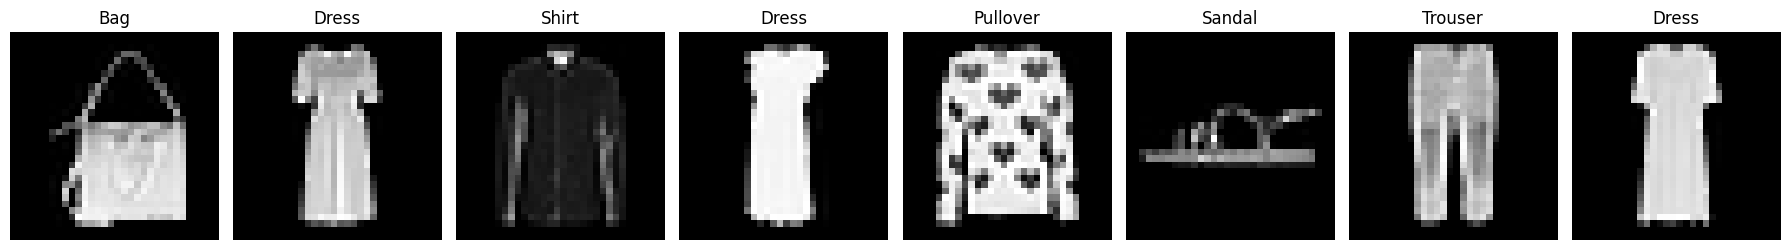

In [12]:
imgs, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[i].imshow(imgs[i, 0], cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(f"{train_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

## Model

In [13]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()
    
def get_dropout(drop_p):
    """ Getting a dropout layer """
    if(drop_p):
        drop = nn.Dropout(p=drop_p)
    else:
        drop = nn.Identity()
    return drop

class Reshape(nn.Module):
    """ Module for reshaping a tensor"""
    def __init__(self, size):
        """ Module initializer"""
        super().__init__()
        self.size = size
        
    def forward(self,x):
        """ Rehaping channel spatial dimension"""
        y = x.view(-1, *self.size)
        return y

In [14]:
class VanillaAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1, 32, 32), sizes=[1024, 128, 10], act="ReLU", dropout_in=0.2, dropout_hid=0.5):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.dropout_in = dropout_in
        self.dropout_hid = dropout_hid
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-1):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append(self.activation)
            if(i == 0):
                layers.append(get_dropout(self.dropout_in))
            else:
                layers.append(get_dropout(self.dropout_hid))

        # replacing last act and dropout with tanh
        layers = layers[:-2] + [nn.Tanh()]  # why TanH?
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
            layers.append(get_dropout(self.dropout_hid))
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-2] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    def forward(self, x):
        """ Forward pass """
        x_flat = x.flatten(start_dim=1)
        z = self.encoder(x_flat)  # latent space values
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        return x_hat, z

## Note:
we use `tanh` as activation function in the `encoder` for two main reasons:
1. Symetric around zero
2. Bounded to -1 and 1

Therefor, we will have a symetric representation of the features, so that later on we can sample from it (Guassian compatible)

Also, `sigmoid` is used in the `decoder`, bcs it is:
1. Perfect for image data where pixel values are normalized to [0,1]
2. Ensures the reconstructed images have valid pixel values
3. BCE loss is compatible with sigmoid

In [15]:
ae = VanillaAE(in_size=(1, 32, 32), sizes=[1024, 128, 10])

In [16]:
ae

VanillaAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1024, bias=True)
    (4): Sigmoid()
  )
)

## Utils

In [17]:
def add_noise(img, mean=0, sigma=0.3):
    """ Adding AWGN to images"""
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma).to(img.device)
    return noisy_img.clamp(0,1)

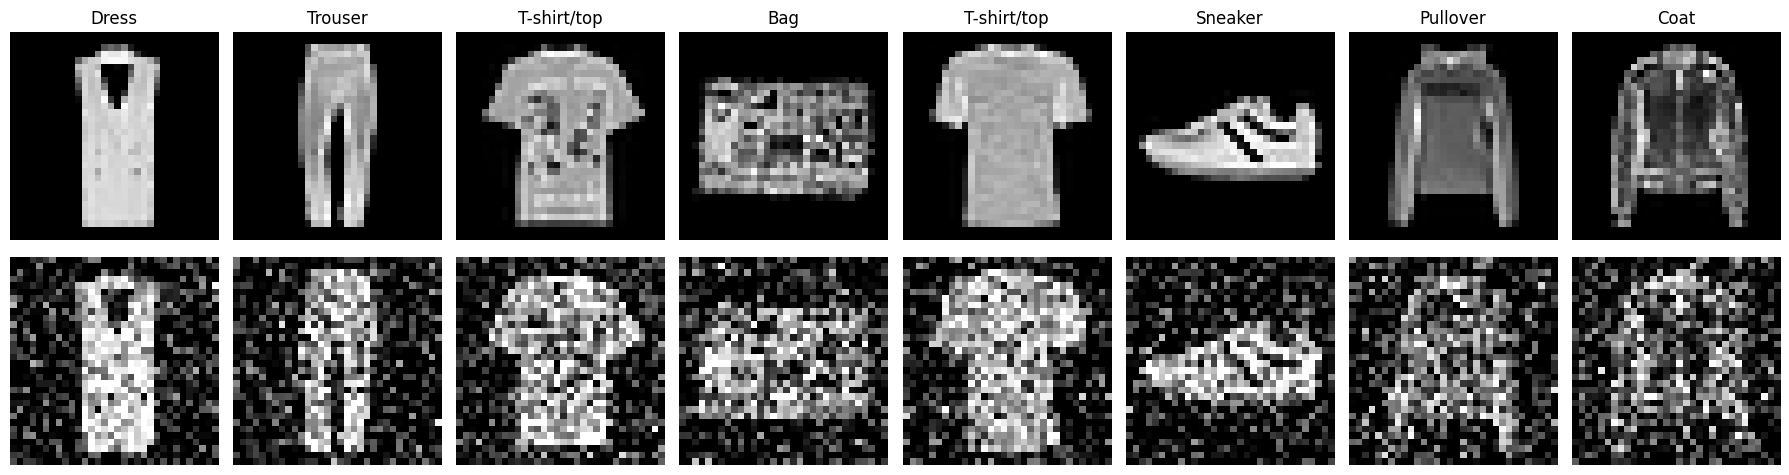

In [18]:
imgs, labels = next(iter(train_loader)) 
noisy_imgs = add_noise(imgs, sigma=0.3)
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[0, i].set_title(f"{train_dataset.classes[labels[i]]}")
    ax[1, i].imshow(noisy_imgs[i, 0], cmap="gray")
    ax[1, i].axis("off")
plt.tight_layout()
plt.show()

In [19]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:  ## Note: we are not using the labels! Unsupervised learning!
        images = images.to(device)
        noisy_images = add_noise(images)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, _ = model(noisy_images)
         
        # Calculate Loss
        loss = criterion(recons, images)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    
    for i, (images, _) in enumerate(eval_loader):
        noisy_images = add_noise(images)
        noisy_images = noisy_images.to(device)
        
        # Forward pass 
        recons, _ = model(noisy_images)
                 
        loss = criterion(recons.cpu(), images)
        loss_list.append(loss.item())
        
        if(i==0 and savefig):
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            save_image( images[:64].cpu(), os.path.join(savepath, f"input_{epoch}.png") )
            save_image( noisy_images[:64].cpu(), os.path.join(savepath, f"noisy_{epoch}.png") ) 
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            if writer is not None:
                grid = torchvision.utils.make_grid(images[:64].cpu())
                writer.add_image('images', grid, epoch)
                grid = torchvision.utils.make_grid(noisy_images[:64].cpu())
                writer.add_image('noisy_images', grid, epoch)
                grid = torchvision.utils.make_grid(recons[:64].cpu())
                writer.add_image('output_images', grid, epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    
    return loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=5, vis_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % vis_frequency == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch)
        writer.add_scalars(f'Loss/Comb', {"train": mean_loss.item(), "valid": loss.item()}, global_step=epoch)
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [20]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

## Training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
ae = VanillaAE(in_size=(1,32,32), sizes=[1024, 512, 128, 64], act="ReLU", dropout_in=0.1, dropout_hid=0.3)
ae = ae.to(device)

In [23]:
ae.encoder

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): Tanh()
)

In [24]:
ae.decoder

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): Sigmoid()
)

In [25]:
# count_model_params(ae)
print(f"Encoder has {count_model_params(ae.encoder)} params")
print(f"Decoder has {count_model_params(ae.decoder)} params")
print(f"Model has {count_model_params(ae)} params")


Encoder has 598720 params
Decoder has 599680 params
Model has 1198400 params


In [26]:
model = ae

### If encoder and decoder are symetric, why this difference?

In [27]:
# regression loss function
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

/home/user/soltania1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [28]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [29]:
savepath = "imgs/vanilla_dae"

train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10,
        savepath=savepath, writer=writer
    )


stats = {
    "train_loss": train_loss,
    "valid_loss": val_loss,
    "loss_iters": loss_iters
}
save_model(model=model, optimizer=optimizer, epoch=20, stats=stats)

Epoch 1 Iter 235: loss 0.04500. : 100%|██████████| 235/235 [00:03<00:00, 59.91it/s]


    Train loss: 0.07154
    Valid loss: 0.18872


Epoch 3 Iter 235: loss 0.02529. : 100%|██████████| 235/235 [00:03<00:00, 62.45it/s]

    Train loss: 0.02705
    Valid loss: 0.02737



Epoch 5 Iter 235: loss 0.02245. : 100%|██████████| 235/235 [00:03<00:00, 62.09it/s]

    Train loss: 0.02303
    Valid loss: 0.02081



Epoch 7 Iter 235: loss 0.02250. : 100%|██████████| 235/235 [00:03<00:00, 60.06it/s]

    Train loss: 0.02187
    Valid loss: 0.01959



Epoch 9 Iter 235: loss 0.02092. : 100%|██████████| 235/235 [00:03<00:00, 62.40it/s]

    Train loss: 0.02117
    Valid loss: 0.01881



Epoch 10 Iter 235: loss 0.02095. : 100%|██████████| 235/235 [00:03<00:00, 59.53it/s]


    Train loss: 0.02091
    Valid loss: 0.01866
Training completed


/tmp/ipykernel_3074983/3751588809.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


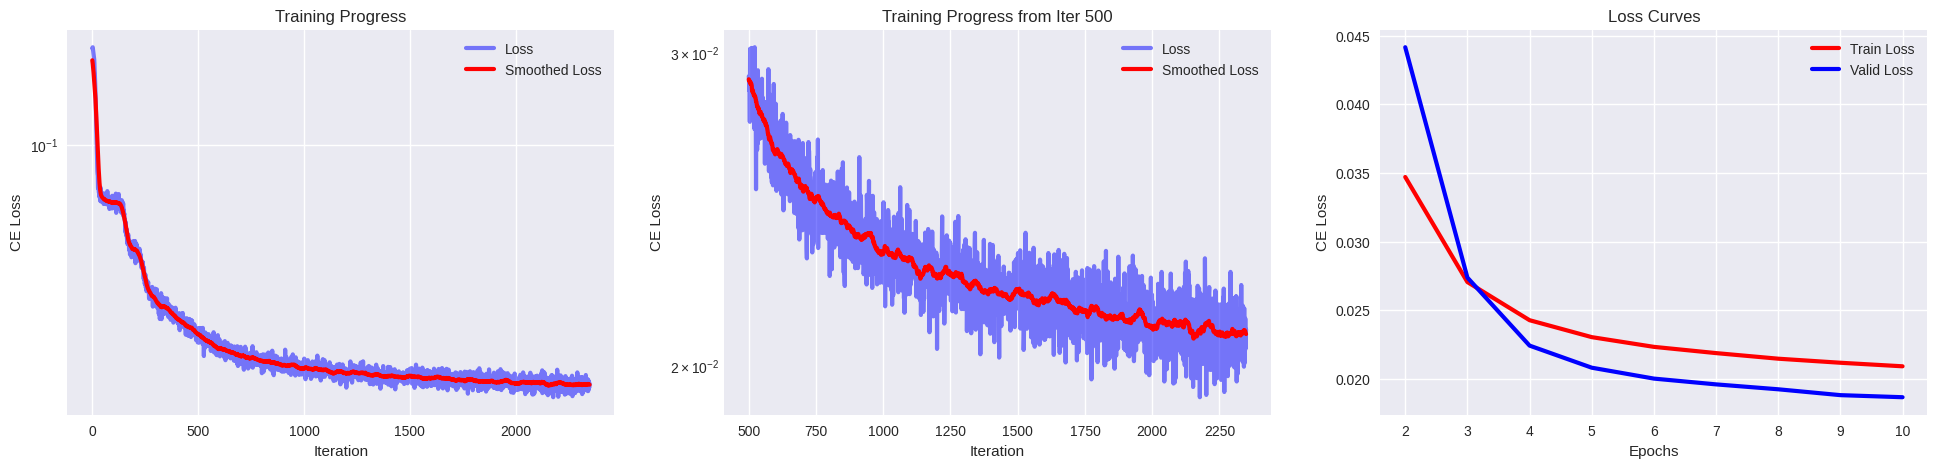

In [30]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

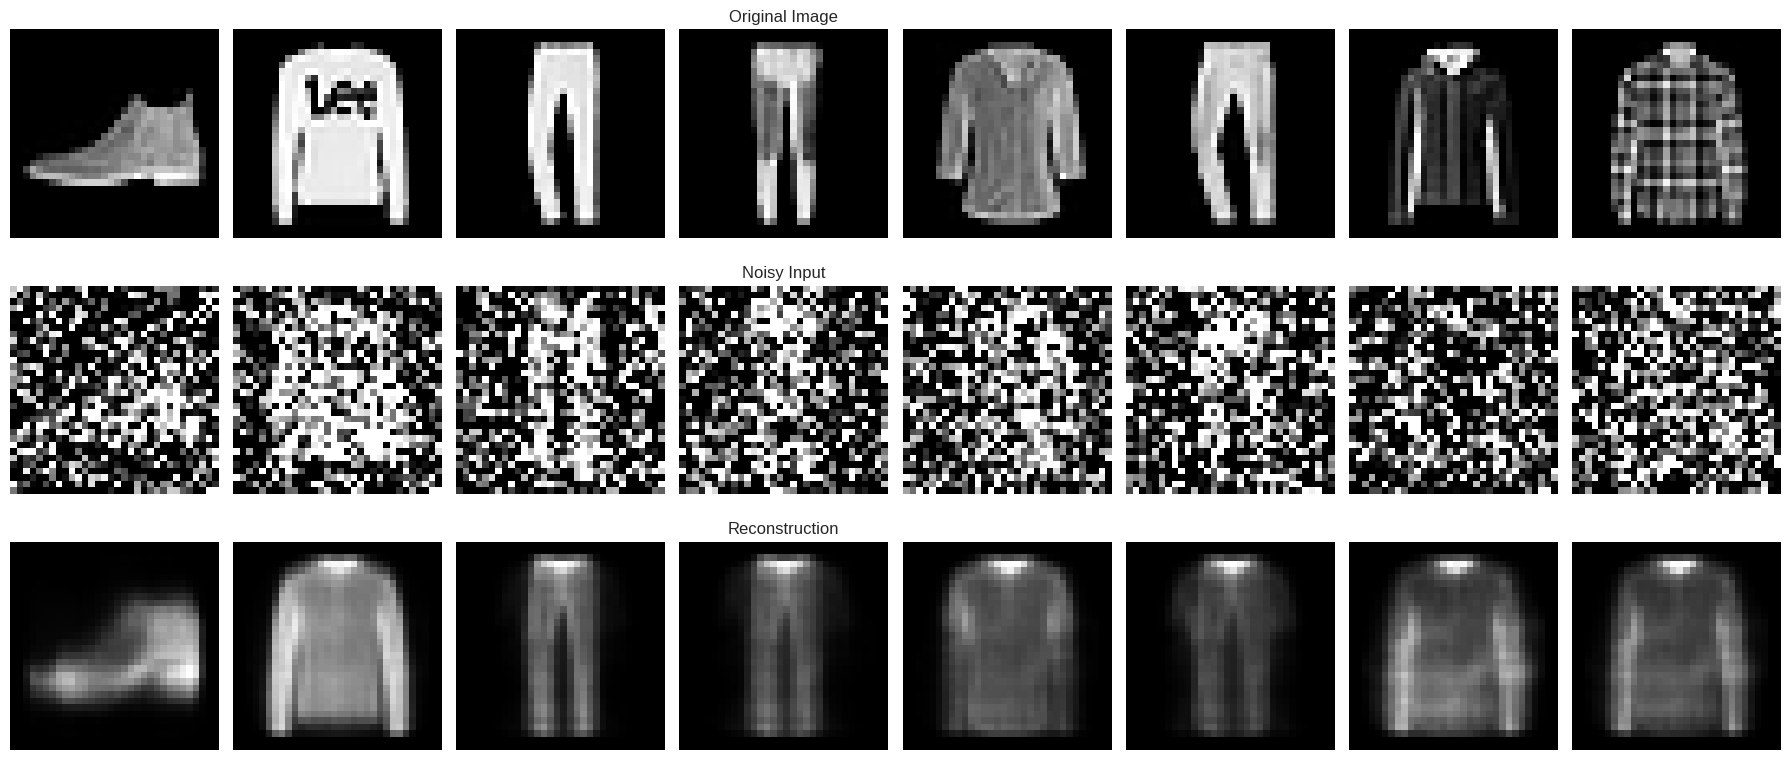

In [31]:
imgs, _ = next(iter(test_loader)) 
noisy_imgs = add_noise(imgs, sigma=0.8)

ae.eval()
with torch.no_grad():
    recons, _ = model(noisy_imgs.to(device))
    
fig, ax = plt.subplots(3, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(noisy_imgs[i, 0], cmap="gray")
    ax[1, i].axis("off")
    ax[2, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[2, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Noisy Input")
ax[2, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

## Some Analysis

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [33]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, z = ae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
    print(latents[0].shape)
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

torch.Size([256, 64])


In [34]:
print(f"{imgs_flat.shape = }")
print(f"{latents.shape = }")

imgs_flat.shape = (10000, 1024)
latents.shape = (10000, 64)


### Note:

So ---> each image is encoded into a 64-dimensional latent vector

The compression ratio here is 1024:64 = 16:1

The model learns to represent the essential features of the image in just 64 numbers

This is a form of dimensionality reduction

In [35]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [36]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

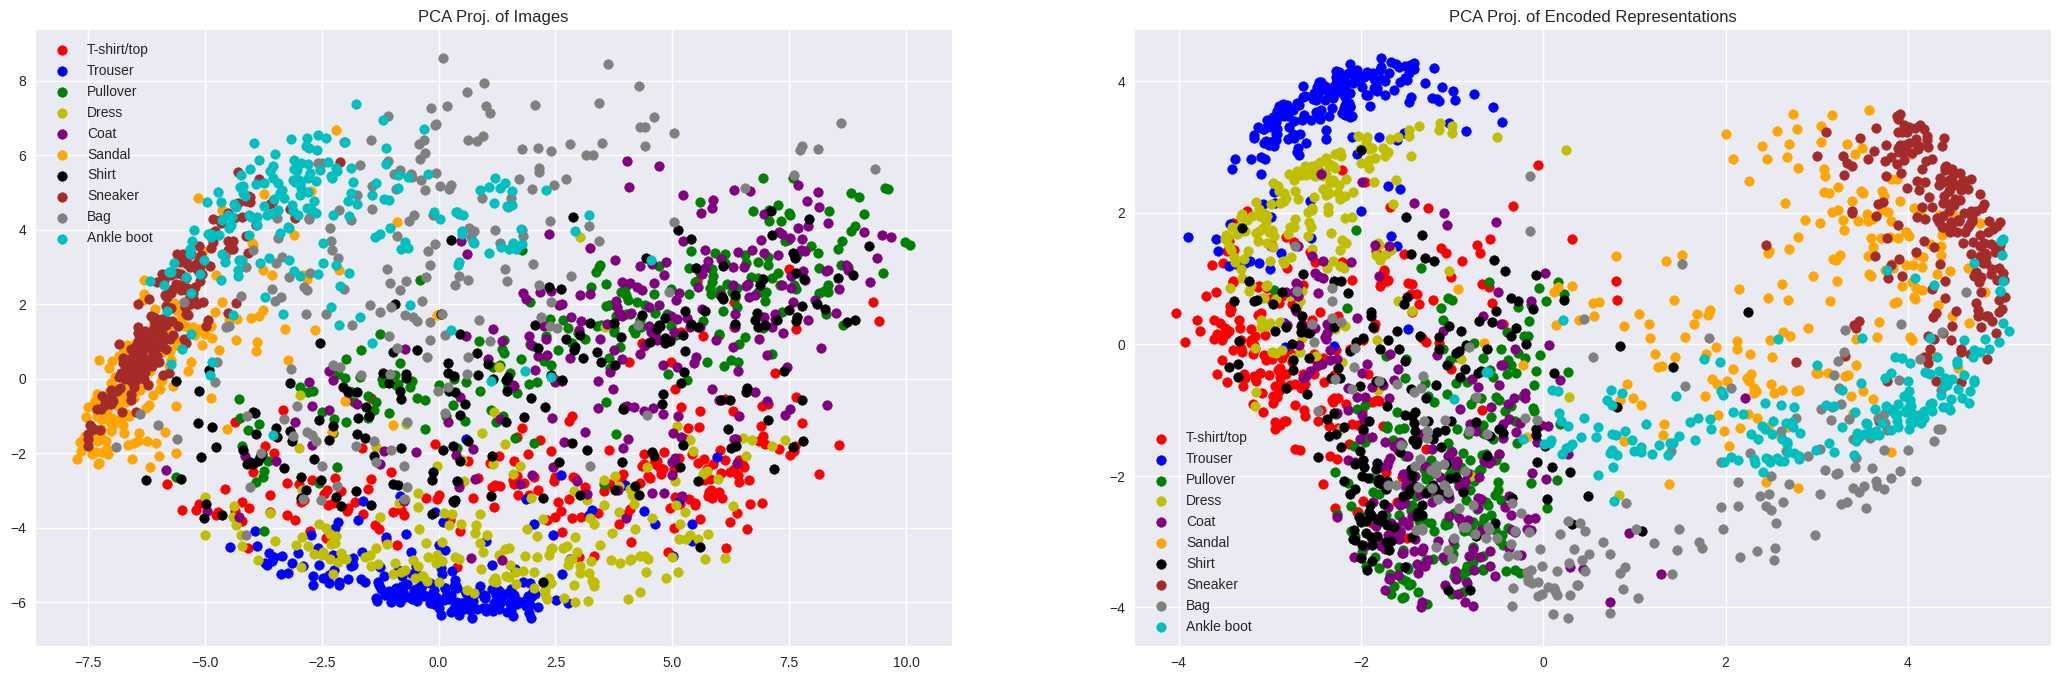

In [37]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

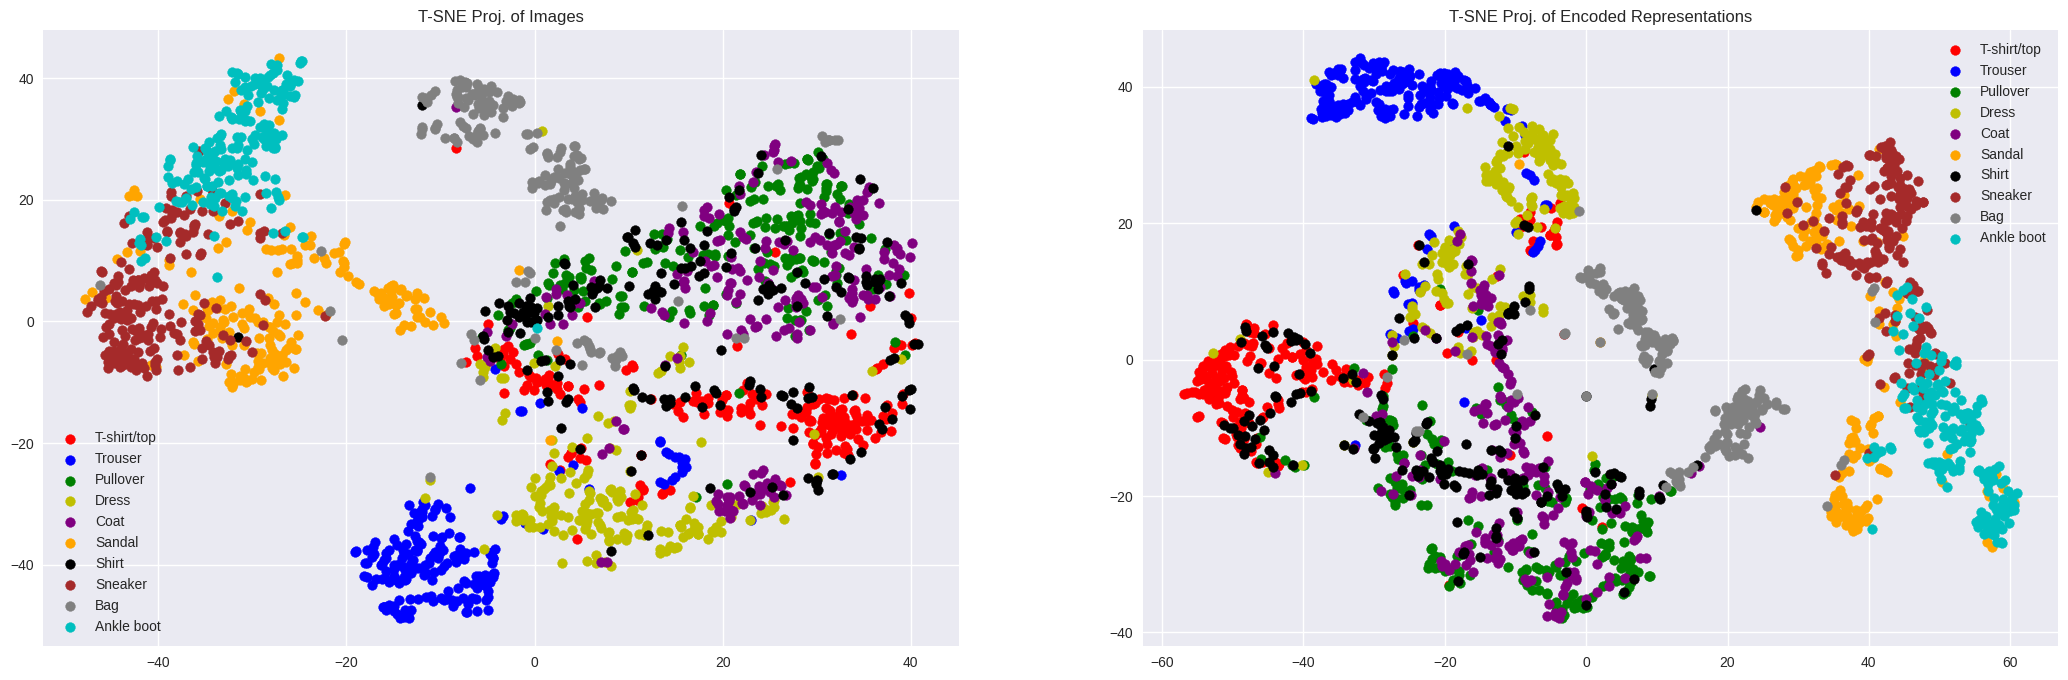

In [38]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

### Clustering

In [39]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

/home/user/soltania1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/user/soltania1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [41]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=35.34%
Clustering latents achieves ARI=40.39%


In [42]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 64/1024  = 6.25%


## Can we generate new data by sampling from the Latent space?

In [45]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 64
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs = ae.decoder(latents)
    print(gen_imgs.shape)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 32, 32)

torch.Size([10, 1024])


### NOTE: 
The decoder has learned to map any point in the 64-dimensional space to a meaningful image
This is a key feature of autoencoders - they can generate new images by sampling from the latent space, even though they were only trained to reconstruct existing images.

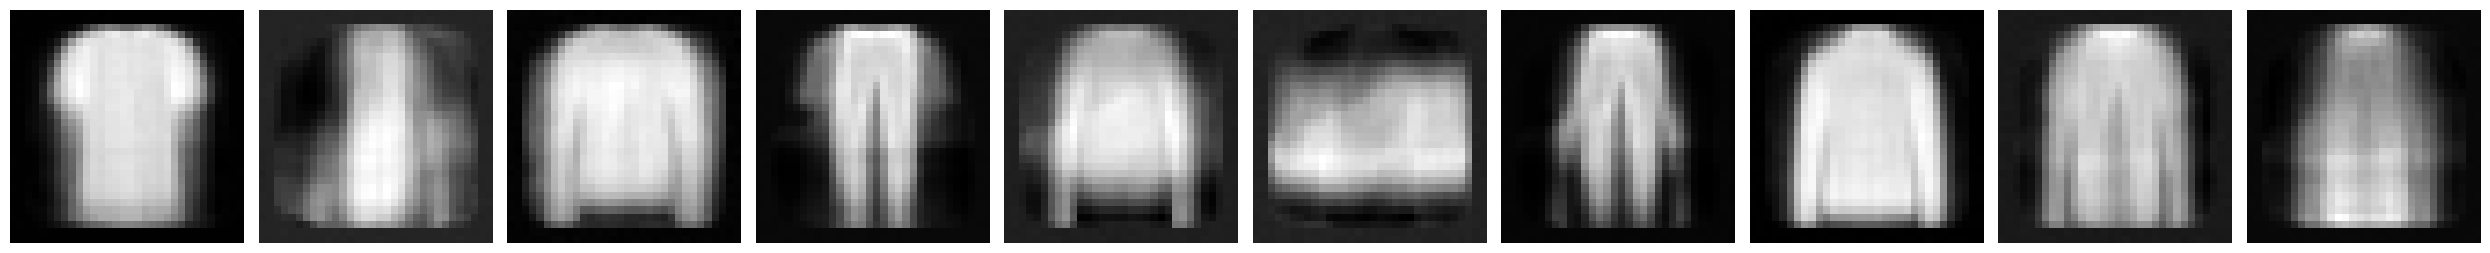

In [44]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

# 4: Variational Autoencoder

## Model

In [46]:
class VanillaVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1, 32, 32), sizes=[1024, 128, 10], act="ReLU"):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-2):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-1] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)  # we can also predict the std directly, but this works best
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, (z, mu, log_var)

In [47]:
vae = VanillaVAE()

In [48]:
vae

VanillaVAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): Sigmoid()
  )
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_sigma): Linear(in_features=128, out_features=10, bias=True)
)

## Training

In [49]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [50]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            if writer is not None:
                grid = torchvision.utils.make_grid(images[:64].cpu())
                writer.add_image('images', grid, epoch)
                grid = torchvision.utils.make_grid(recons[:64].cpu())
                writer.add_image('output_images', grid, epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=5, vis_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % vis_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch)
        writer.add_scalars(f'Loss/All_Valid_Loss', {"recons": recons_loss.item(), "kld": kld_loss.item()}, global_step=epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch)
        writer.add_scalars(f'Loss/Comb', {"train": mean_loss.item(), "valid": loss.item()}, global_step=epoch)
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld



In [51]:
vae = VanillaVAE(in_size=(1,32,32), sizes=[1024, 256, 128, 64, 2], act="ReLU")
vae = vae.to(device)

In [62]:
vae

VanillaVAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1024, bias=True)
    (7): Sigmoid()
  )
  (fc_mu): Linear(in_features=64, out_features=2, bias=True)
  (fc_sigma): Linear(in_features=64, out_features=2, bias=True)
)

In [52]:
count_model_params(vae)

608516

In [54]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_vae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [55]:
savepath = "imgs/vanilla_vae"
model = vae

In [56]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

/home/user/soltania1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [57]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 235: loss 0.03021. : 100%|██████████| 235/235 [00:03<00:00, 63.54it/s]


    Train loss: 0.04915
    Valid loss: 0.18941
       Valid loss recons: 0.18939
       Valid loss KL-D:   0.01055


Epoch 3 Iter 235: loss 0.02678. : 100%|██████████| 235/235 [00:03<00:00, 60.06it/s]

    Train loss: 0.02949
    Valid loss: 0.03006
       Valid loss recons: 0.02552
       Valid loss KL-D:   4.54377



Epoch 5 Iter 235: loss 0.02798. : 100%|██████████| 235/235 [00:03<00:00, 64.55it/s]

    Train loss: 0.02834
    Valid loss: 0.02868
       Valid loss recons: 0.02408
       Valid loss KL-D:   4.59425



Epoch 7 Iter 235: loss 0.02779. : 100%|██████████| 235/235 [00:03<00:00, 63.75it/s]

    Train loss: 0.02792
    Valid loss: 0.02828
       Valid loss recons: 0.02359
       Valid loss KL-D:   4.69449



Epoch 9 Iter 235: loss 0.02970. : 100%|██████████| 235/235 [00:03<00:00, 58.95it/s]


    Train loss: 0.0275
    Valid loss: 0.02769
       Valid loss recons: 0.02299
       Valid loss KL-D:   4.70012


Epoch 10 Iter 235: loss 0.02729. : 100%|██████████| 235/235 [00:03<00:00, 65.05it/s]

    Train loss: 0.02744
    Valid loss: 0.0274
       Valid loss recons: 0.02273
       Valid loss KL-D:   4.67472
Training completed


In [58]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

/tmp/ipykernel_3074983/892720532.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


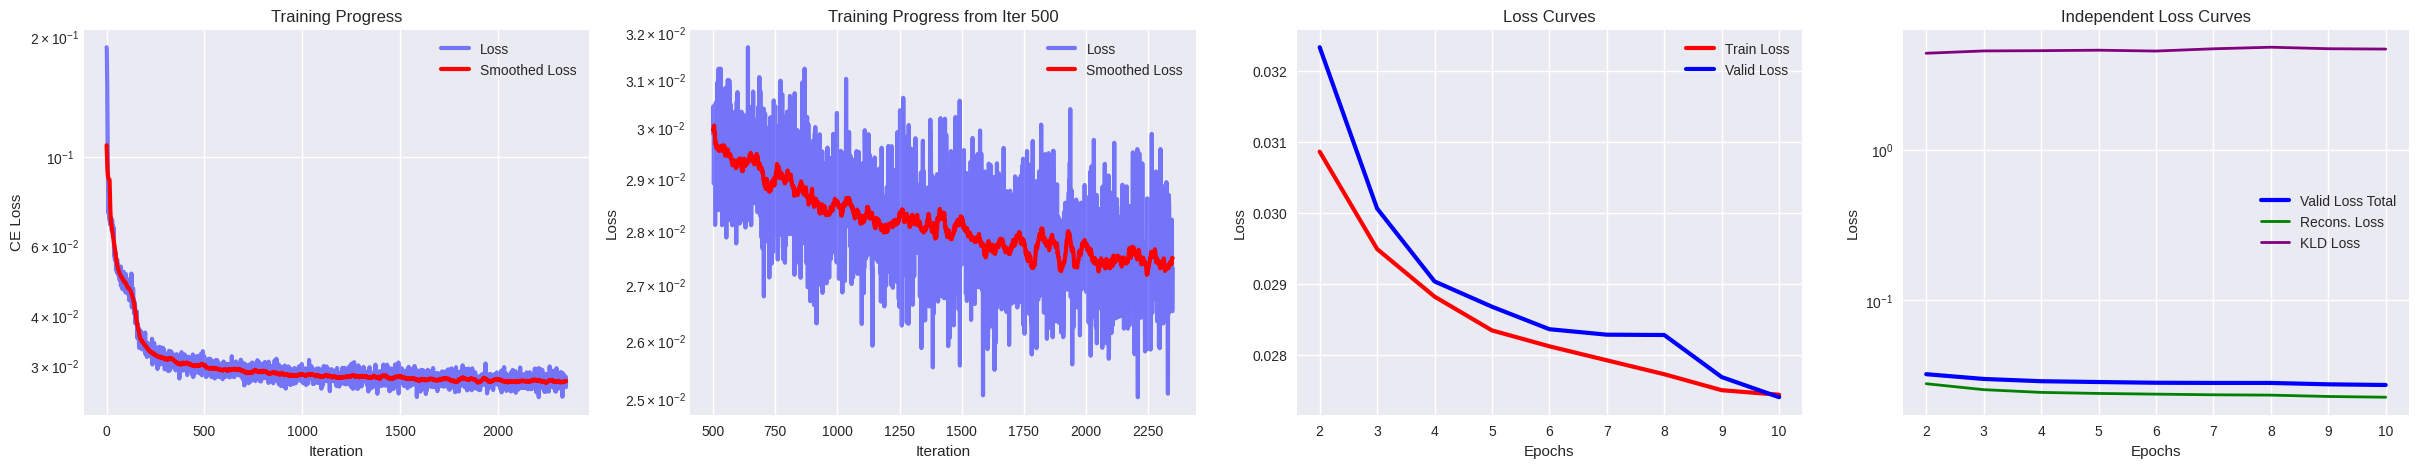

In [59]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

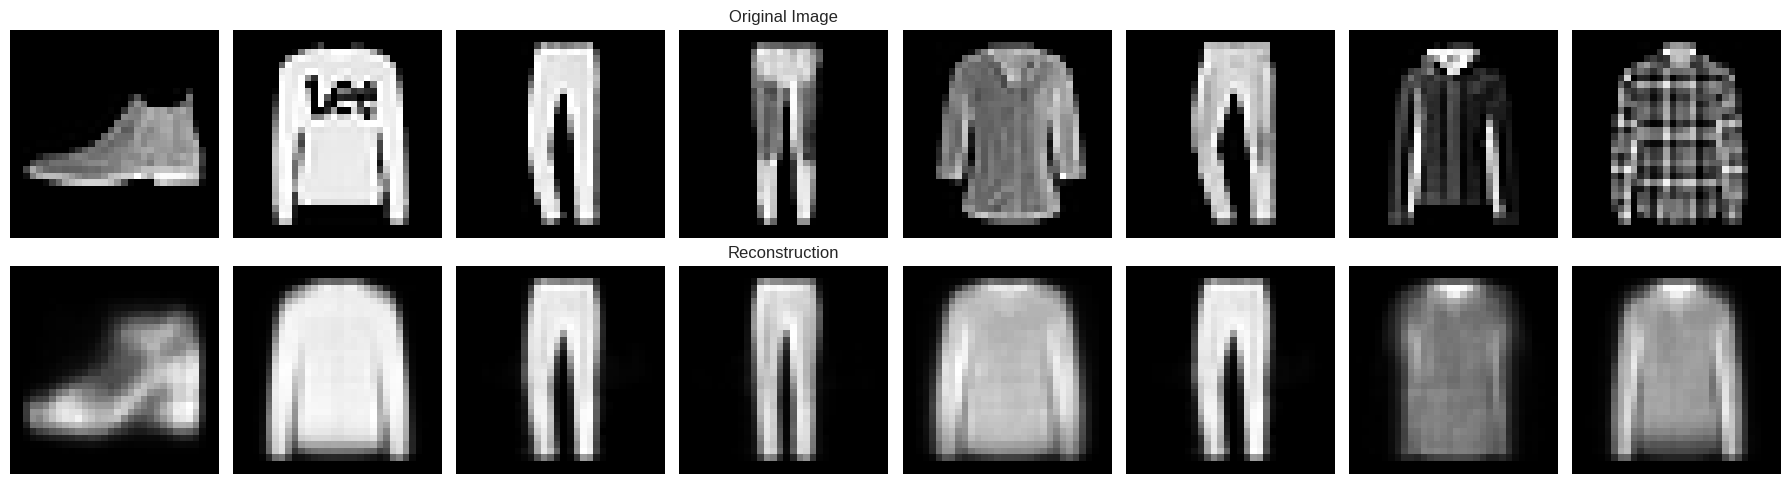

In [60]:
imgs, _ = next(iter(test_loader)) 

ae.eval()
with torch.no_grad():
    recons, _ = model(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

## Inference 

Generating new clothes from latent codes

In [61]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [63]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 2).to(device)
        sample = vae.decoder(z)
    
        save_image(sample.view(64, 1, 32, 32), f"imgs/inferecence_vae/inference_{i}.png")

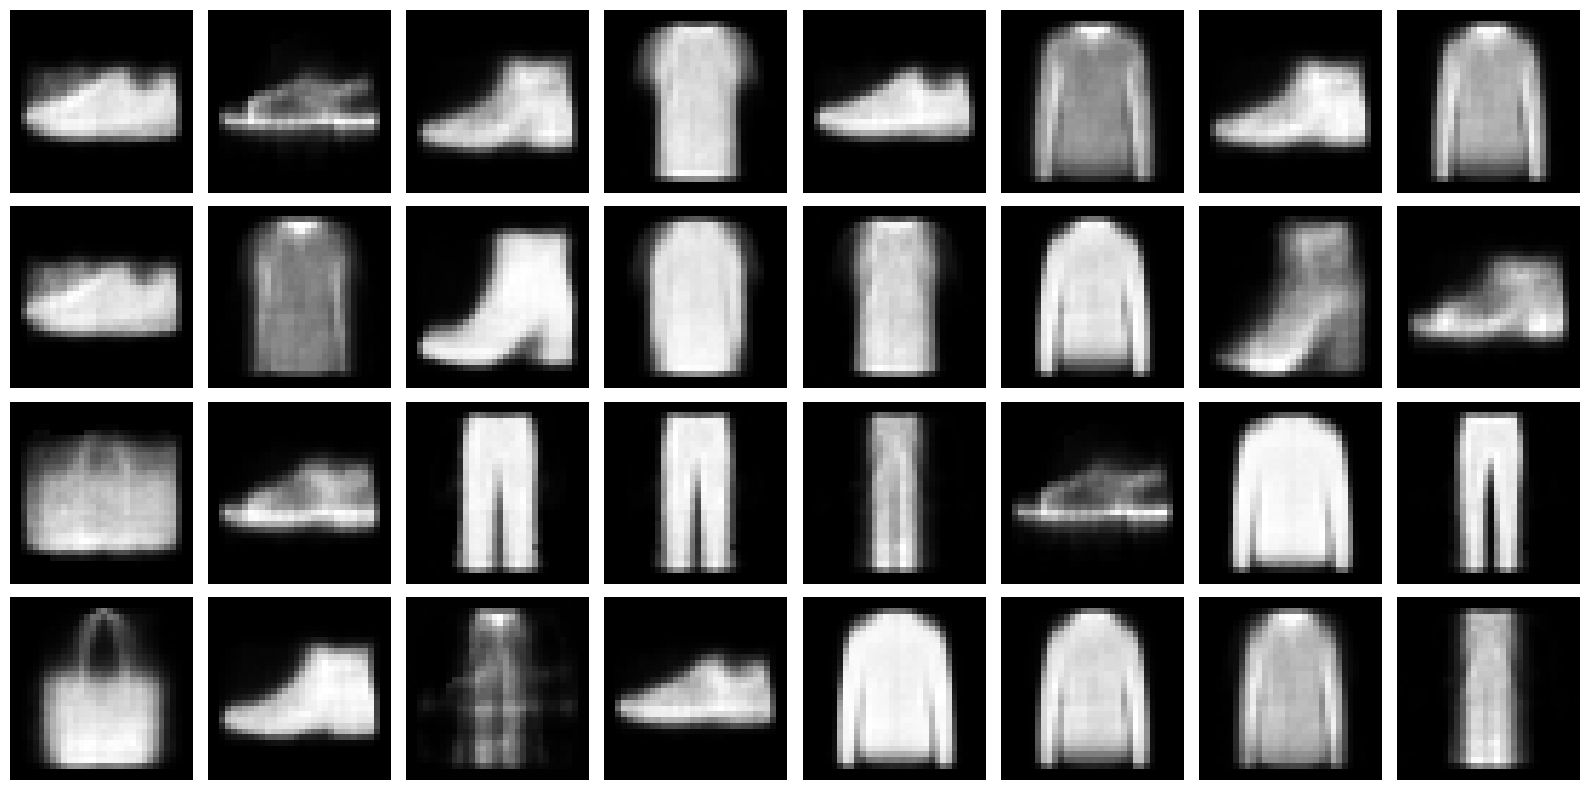

In [64]:
recons = sample.view(64, 1, 32, 32)
plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(recons[i, 0].cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Analysis

In [65]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

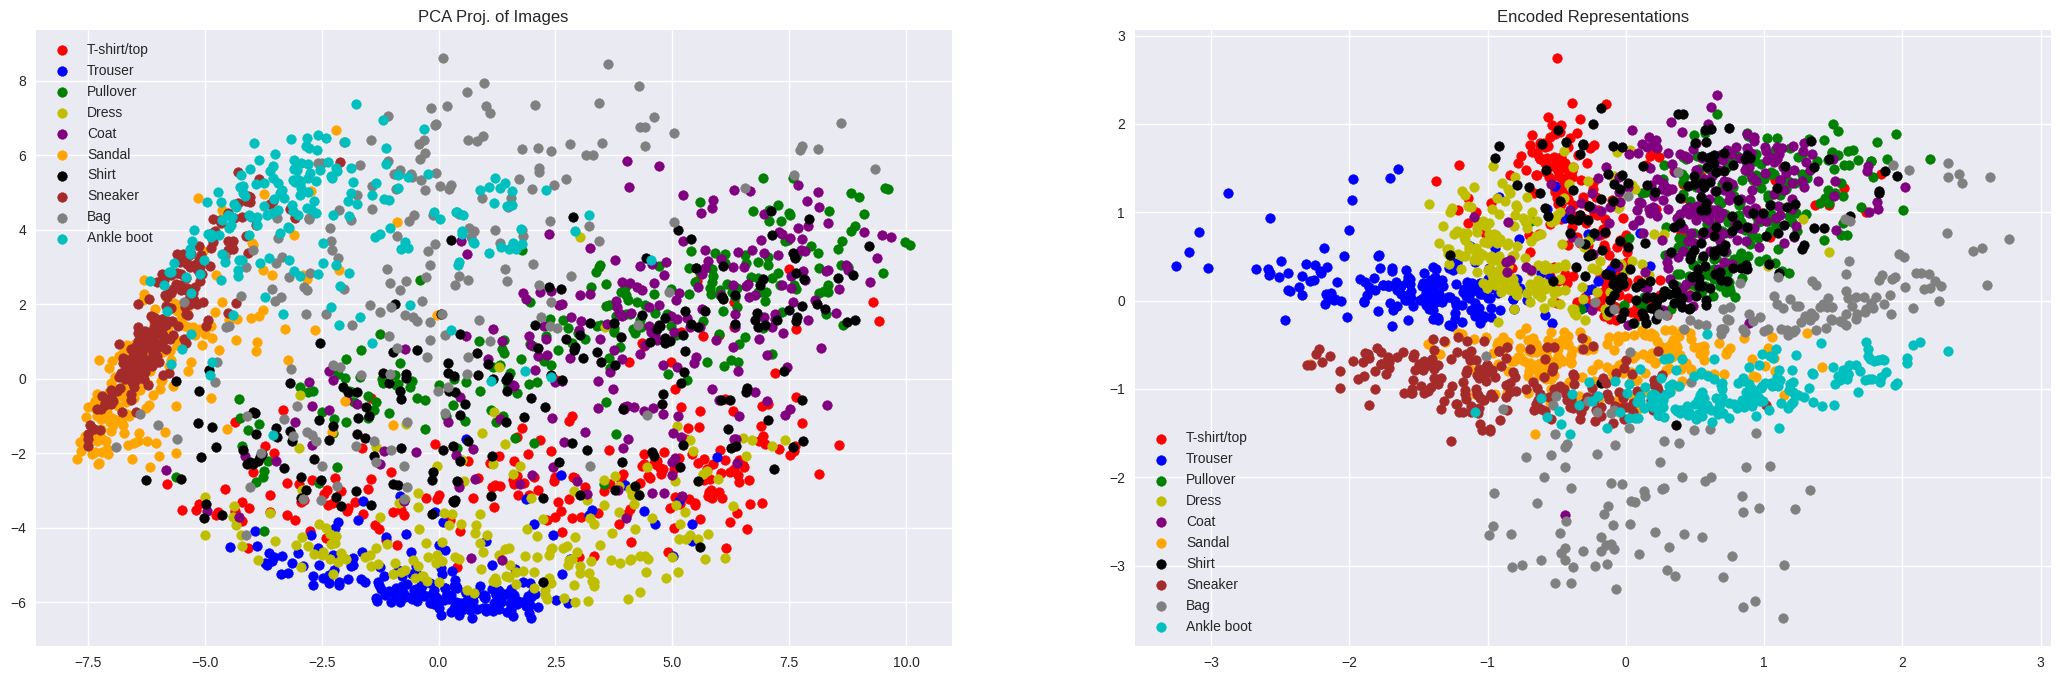

In [66]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

# N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

## Interpolation

In [67]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device) #Generating linspace points
            x_hat = model.decoder(z).cpu()  # sending them throuhg decoder
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")
    plt.show()

1. Understanding the Latent Space:
The latent space is a compressed representation of images
By sampling different points, we can see how the decoder maps these points to images
2. Helps us understand what the model has learned
Visualization of the Model's Behavior:
Shows how the model generalizes to new inputs
Reveals the structure of the learned latent space
Helps identify if the model has learned meaningful features
3. Interpolation and Generation:
By sampling points, we can generate new images
Can interpolate between known images by moving through the latent space
Useful for understanding how the model generalizes

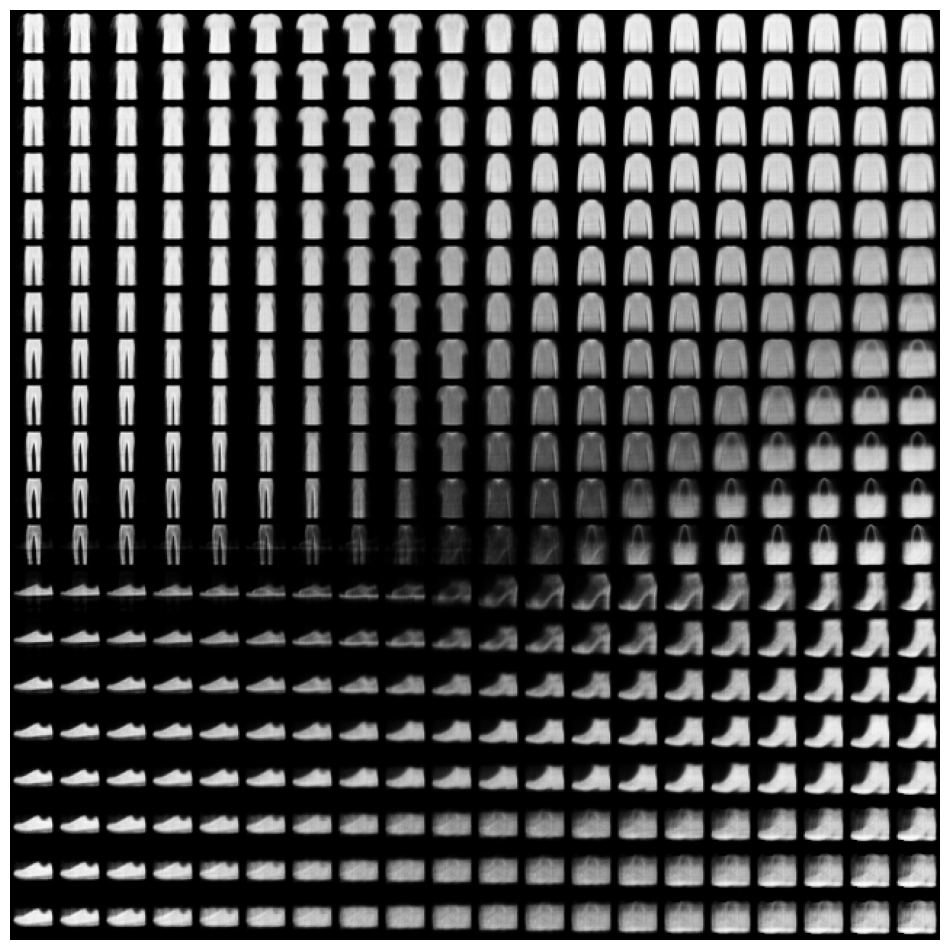

In [68]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=20)

In [72]:
img1 = test_dataset[1607][0]
img2 = test_dataset[1610][0]

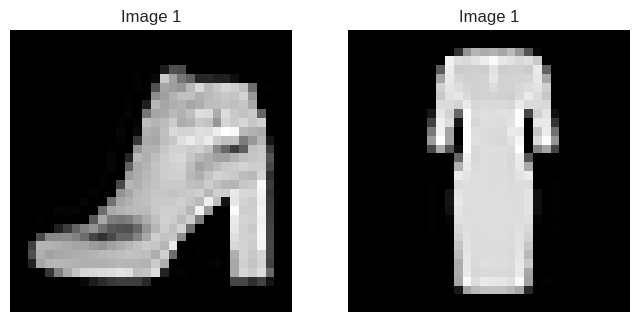

In [73]:
plt.subplot(1,2,1)
plt.imshow(img1[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [74]:
with torch.no_grad():
    encoded = model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [76]:
latent1

tensor([ 1.5011, -0.7739], device='cuda:0')

In [75]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decoder (z)
    decoded_imgs = decoded.cpu().view(-1,32,32)
    return decoded_imgs

In [78]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=18)

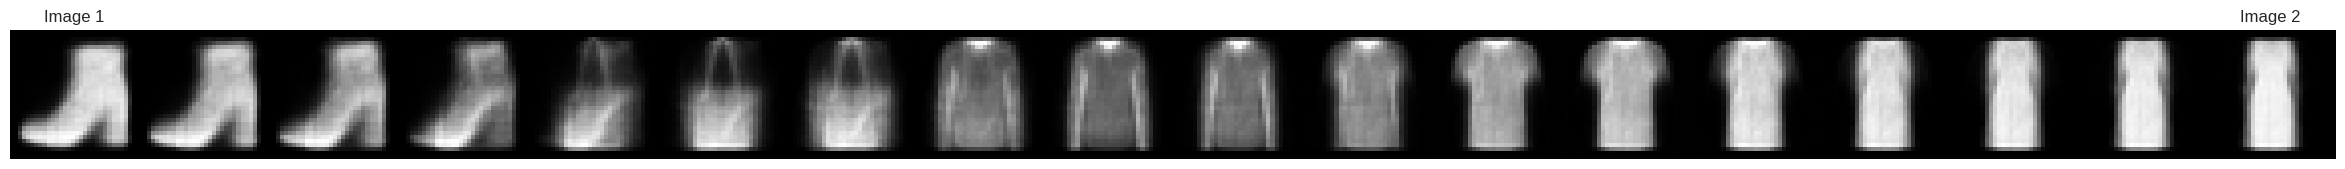

In [79]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

# Assignment 4
 - a) We will be working with the **AFHQ (Animal Faces-HQ)** dataset: https://github.com/clovaai/stargan-v2
    - Approx 15.000 images of animal faces (cat, dog, tiger, ...)
    - Downsample the images to 64x64
 - b) Write **Convolutional** Variational Autoencoder (ConvVAE)
      - Use Conv. layers for encoder and Transposed-Conv. layers for decoder.
      - You are only allowed to use linear layers for estimating the mean and standard deviation. Everything else should be convolutional.
 - c) Investigate the importance of the KL-divergence weight. For this purpose, train multiple models (at least 4) using different weighting values and investigate how this value affects the generation performance.
 - d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.
 - e) Compare the models from b) and c)
     - Qualitative comparison. Which images look better?
     - Quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
     - Log generated images and losses into the Tensorboard/W&B
     
     
**Extra Point:**
 - Extend your ConvVAE for Image generation conditioned on a given class. The AFHQ dataset has 3 classes: 'cat', 'dog', and 'wildlife'
 - Train your Conditional-ConvVAE
 - Show that you can generate images conditioned on a label
 - Tutorial: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

#### **Due Date**: Monday 2nd June at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment4 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, Tensorboard logs, and any other .py files or images used.

#### **Next Session** Wednesday 4th June

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://github.com/lyeoni/pytorch-mnist-VAE
 - https://towardsdatascience.com/reparameterization-trick-126062cfd3c3
 - https://ijdykeman.github.io/ml/2016/12/21/cvae.html

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  